<a href="https://colab.research.google.com/github/mschristophers/computer-vision-bootcamp/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Header

In [ ]:
"""
This is a starter file to get you going. You may also include other files if you feel it's necessary.

Make sure to follow the code convention described here:
https://github.com/UWARG/computer-vision-python/blob/main/README.md#naming-and-typing-conventions

Hints:
* The internet is your friend! Don't be afraid to search for tutorials/intros/etc.
* We suggest using a convolutional neural network.
* TensorFlow Keras has the CIFAR-10 dataset as a module, so you don't need to manually download and unpack it.
"""

## Imports

In [12]:
# Importing the modules, libraries, and datasets
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import cifar10

## Data Pre-processing

In [20]:
def data_preprocessing():
  """
  Loads and preprocesses the data from CIFAR-10 dataset, which then returns the
  training and test data.
  """

  (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

  # Normalized data by rescaling pixel values into [0,1]
  X_train = X_train.astype('float32')/255.0
  X_test = X_test.astype('float32')/255.0

  # Convert data into binary class matrix
  Y_train = tf.keras.utils.to_categorical(Y_train)
  Y_test = tf.keras.utils.to_categorical(Y_test)

  return X_train, Y_train, X_test, Y_test

## Modeling

In [19]:
def model():
  """
  Creates a CNN model with a sequential model
  """

  # CNN Model
  cnnModel = models.Sequential()

  # Input Layer
  cnnModel.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (32, 32, 3)))
  cnnModel.add(layers.MaxPool2D((2,2)))
  cnnModel.add(layers.Dropout(0.2))

  # Layer 2
  cnnModel.add(layers.Conv2D(128, (3,3), activation = 'relu'))
  cnnModel.add(layers.MaxPool2D((2,2)))
  cnnModel.add(layers.Dropout(0.2))

  # Flattened layers
  cnnModel.add(layers.Flatten())

  # Layer 3
  cnnModel.add(layers.Dense(512, activation = 'relu'))

  # Output Layer
  cnnModel.add(layers.Dense(10, activation = 'softmax'))

  # Compiler
  cnnModel.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return cnnModel

## Plotting

In [18]:
def plotting(history):
  """
  Shows the loss plot of training and validation over epochs
  """

  # Loss plot
  plt.clf()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc="upper left")
  plt.show()

## Main Function

In [22]:
def main():
  """
  Processes, trains, and tests the model
  """

  X_train, Y_train, X_test, Y_test = data_preprocessing()

  modelling = model()

  # Data fitting
  history = modelling.fit(X_train, Y_train, epochs=11, batch_size=64, validation_data=(X_test, Y_test))

  plotting(history)
  

## Running

Epoch 1/11
782/782 [==============================] - 135s 172ms/step - loss: 1.4888 - accuracy: 0.4733 - val_loss: 1.1907 - val_accuracy: 0.5781
Epoch 2/11
782/782 [==============================] - 131s 167ms/step - loss: 1.0580 - accuracy: 0.6319 - val_loss: 1.0683 - val_accuracy: 0.6276
Epoch 3/11
782/782 [==============================] - 130s 167ms/step - loss: 0.8857 - accuracy: 0.6931 - val_loss: 1.1395 - val_accuracy: 0.6149
Epoch 4/11
782/782 [==============================] - 132s 168ms/step - loss: 0.7545 - accuracy: 0.7397 - val_loss: 0.9977 - val_accuracy: 0.6509
Epoch 5/11
782/782 [==============================] - 129s 165ms/step - loss: 0.6469 - accuracy: 0.7761 - val_loss: 0.8582 - val_accuracy: 0.7150
Epoch 6/11
782/782 [==============================] - 130s 166ms/step - loss: 0.5601 - accuracy: 0.8079 - val_loss: 0.9832 - val_accuracy: 0.6753
Epoch 7/11
782/782 [==============================] - 128s 164ms/step - loss: 0.4876 - accuracy: 0.8344 - val_loss: 0.8511 -

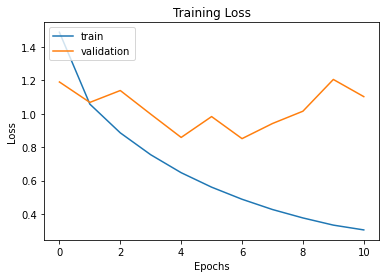

In [23]:
# Runs the main function
main()
